# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

550x550 size

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from fastai.callbacks.tracker import SaveModelCallback
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(0)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: 6005e597, DATE: 20191218


In [6]:
UID='37c69040'
DATE='20191217'
NB='02_07_2'

In [7]:
INFERENCE_MODEL=f'{NB}-{UID}_unet_squish-s2-r0-{DATE}'

In [8]:
SUBSET_DATA=False
SUBSET_LEN=171
VAL_FILE='val_20pct_2.csv'

In [9]:
tgt_height = 550
data_dir = Path('data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped/mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

test_img = train_images/'cropped/mask_fill/test'


In [10]:
filename = 'data/CAX_LogFacies_Train_File.csv'

In [11]:
file_test = 'data/CAX_LogFacies_Test_File.csv'

#### all data

In [12]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()


,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [13]:
test_df = pd.read_csv(file_test)
test_df.head()


,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


### Data

In [14]:
train_img_names = get_image_files(train_img)
len(train_img_names)

28000

In [15]:
train_img_names[:3]

[PosixPath('data/train_images/cropped/mask_fill/train/images/well_3666_crop_3.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/images/well_3886_crop_6.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/images/well_2037_crop_6.png')]

In [16]:
for im in train_img_names:
    assert 'crop' in str(im)

In [17]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('data/train_images/cropped/mask_fill/train/masks/well_3666_crop_3.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/masks/well_3886_crop_6.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/masks/well_2037_crop_6.png')]

In [18]:
for im in train_mask_names:
    assert 'crop' in str(im)

### Data QC

In [19]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [20]:
train_img_names[0]

PosixPath('data/train_images/cropped/mask_fill/train/images/well_3666_crop_3.png')

In [21]:
missing_i_m=set(inames) - set(mnames)

In [22]:
missing_m_i= set(mnames)-set(inames) 

In [23]:
assert len(missing_i_m)==len(missing_m_i)==0

In [24]:
len(inames)

28000

In [25]:
len(mnames)

28000

data/train_images/cropped/mask_fill/train/images/well_2389_crop_1.png


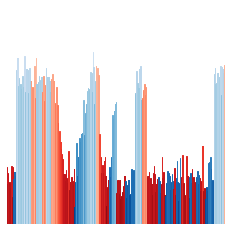

In [26]:
img_f = train_img_names[5]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

### Link Masks with Images

In [27]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [28]:
get_y_fn(img_f)

PosixPath('data/train_images/cropped/mask_fill/train/masks/well_2389_crop_1.png')

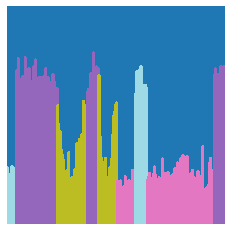

In [29]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [30]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        u_values.extend(np.unique(mask.tolist()))
    return u_values

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [31]:
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

In [32]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([275, 275]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [5, 5, 5,  ..., 2, 2, 2],
          [5, 5, 5,  ..., 2, 2, 2],
          [5, 5, 5,  ..., 2, 2, 2]]]))

In [33]:
gr_size = np.array(img_gr.shape[1:])
gr_size

array([275, 275])

## Datasets

In [62]:
bs = 4
#size=src_size//2
#squish to square

size=(tgt_height, tgt_height)

In [63]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [64]:
src = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file(f'../{VAL_FILE}', path=train_img)
    .label_from_func(get_y_fn, classes=codes))

In [65]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [66]:
len(src.train.x)

22400

In [67]:
src_test = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file(f'../{VAL_FILE}', path=train_img)
    .label_from_func(get_y_fn, classes=codes)
    .add_test_folder(test_folder='../../test_6', tfms=None, tfm_y=False))

In [68]:
data_test = (src_test.transform(size=size, tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [69]:
data.train_ds.x[0].shape

torch.Size([3, 275, 275])

In [70]:
data_test.valid_ds.x[0].shape

torch.Size([3, 275, 275])

In [71]:
data.train_ds.y[0].shape

torch.Size([1, 275, 275])

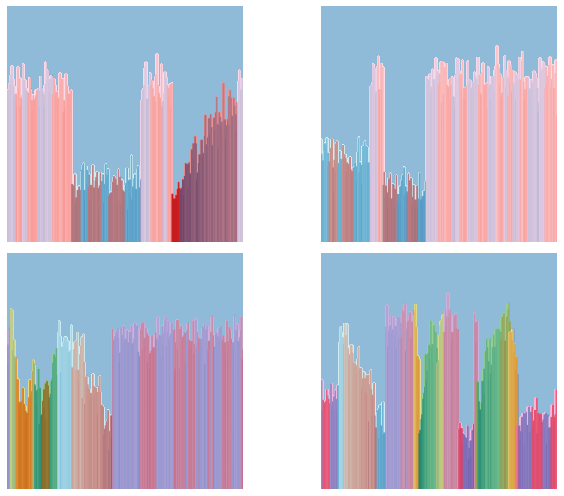

In [72]:
data.show_batch(4, figsize=(10,7))

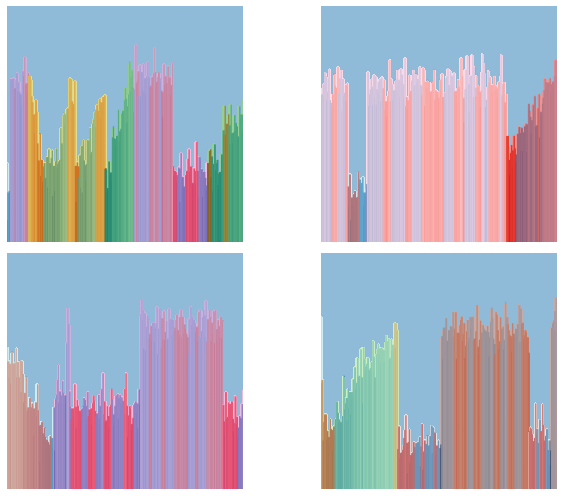

In [73]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [46]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [47]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_camvid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [48]:
wd=1e-2

In [49]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()

In [50]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [51]:
learn.load(f'{INFERENCE_MODEL}')
learn=learn.to_fp32()
learn.export(f'{INFERENCE_MODEL}.pkl')

In [52]:
gc.collect()

20

### Inference

In [53]:
#wd=1e-2
#learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()
#test_data = SegmentationItemList.from_folder(test_img)
#learn=None

In [78]:
test_img = train_images/'cropped/mask_fill/test'

In [79]:
test_data = SegmentationItemList.from_folder(test_img)

In [80]:
learn = load_learner(path=train_img, file=f'{INFERENCE_MODEL}.pkl', test=test_data, tfm_y=False, dl_tfms=None)
learn=learn.to_fp16()
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [81]:
learn.data.batch_size=8

In [82]:
learn.data.test_ds.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [83]:
#learn.data.test_ds.tfms=None
#learn.data.train_ds.tfms=None
#learn.data.valid_ds.tfms=None

In [84]:
#im = train_images/'cropped/mask_fill/test/cropped/well_5000_GR_crop_0.png'
#img=pil_image.open(im)
#prediction = learn.predict(img)

In [ ]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

In [ ]:
preds.shape

In [ ]:
preds[0].shape

In [ ]:
labels = np.argmax(preds, 1)

In [ ]:
learn.data.classes

In [ ]:
len(labels)

In [ ]:
labels.shape

As a first pass we want the mode (most common) class for each column in the image

But we want to first ignore background

Lets check a single prediction first

Mult by 40 so can see different colours

In [ ]:
npa=labels[0].numpy().astype(np.int32)*40

In [ ]:
type(npa[0][0])

In [ ]:
img = pil_image.fromarray(npa)

In [ ]:
plt.imshow(img)

In [ ]:
labels[0].shape

In [ ]:
labels.shape

In [ ]:
labels.shape[0]

Example code for calculating median of columns in numpy array but ignoring 0 (background)

<pre>
n=np.array([[0,2,1], [0,1,3], [1,2,3]])
m_mask = n != 0  
new_m = np.where(m_mask, n, np.nan)
m=mode(new_m, axis=0)
r=m[0]
r=r[0].astype(int)
</pre>

In [ ]:
test_df.head()

In [ ]:
test_data.items

In [ ]:
test_data

In [ ]:
def get_well_list(test_data):
    ids=[]
    for f in test_data:
        id=f.name.split('_')[1]
        ids.append(id)
    return ids

In [ ]:
v=test_data.items.tolist()
well_ds=get_well_list(v)

In [ ]:
len(well_ds)

In [ ]:
labels.shape[0]

In [ ]:
def calc_mean_on_cols(labels,well_ids):
    print(f'len(well_ids): {len(well_ids)}, labels.shape[0]: {labels.shape[0]}')
    frames=[]
    for i, id in enumerate(well_ids):
        row_ids=range(len(labels[i]))
        n=labels[i]
        m_mask = n != 0  
        new_m = np.where(m_mask, n, np.nan)
        m=mode(new_m, axis=0)
        r=m[0].flatten().astype(int)
        well_col=[id] * len(n)
        tdf = pd.DataFrame({'row_id': row_ids, 'facies': r,
                            'well_id': well_col})
        frames.append(tdf)
    df = pd.concat(frames)
    return df

In [ ]:
df=calc_mean_on_cols(labels,well_ds)

In [ ]:
len(df)

In [ ]:
df.tail()

In [ ]:
df = df.sort_values(by=['well_id', 'row_id'])

In [ ]:
df.head()